In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
tweets = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
duplicates = tweets.duplicated(subset = 'text', keep = False)
duplicates.value_counts()

False    7434
True      179
dtype: int64

In [4]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7378 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


In [23]:
tweets['keyword'] = tweets.keyword.str.replace('%20',' ')

In [5]:
import string

tweets['text'] = tweets['text'].apply(lambda x: x.translate({ord(i): ' ' for i in string.punctuation}))
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are ...,1
3,6,NaN,NaN,13 000 people receive wildfires evacuation or...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as ...,1


In [6]:
tweets['text'] = tweets['text'].apply(lambda x: x.lower())

In [7]:
import io
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matiascano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def remove_stopword(text):
    new_text = []
    for e in text:
        if e not in stopwords and e.isalpha():
            new_text.append(e)
    text = new_text
    return " ".join(new_text)

In [9]:
tweets['text'] = tweets['text'].str.split()
tweets['text'] = tweets['text'].apply(remove_stopword)
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [10]:
stemmer = SnowballStemmer('english')

In [11]:
def stemm(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [12]:
tweets['text'] = tweets['text'].apply(stemm)
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


### Clustering graphic

* SVD

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

x_train, x_test, y_train, y_test = \
train_test_split(tweets['text'], tweets['target'], test_size = 0.25, random_state = 123)

tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [27]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
svd.fit(x_train_tfidf)
svd_result = svd.transform(x_train_tfidf)

In [51]:
to_plot = pd.DataFrame({'x': svd_result[:, 0], 'y': svd_result[:, 1], 'target': y_train})

In [57]:
to_plot.reset_index(inplace=True, drop=True)

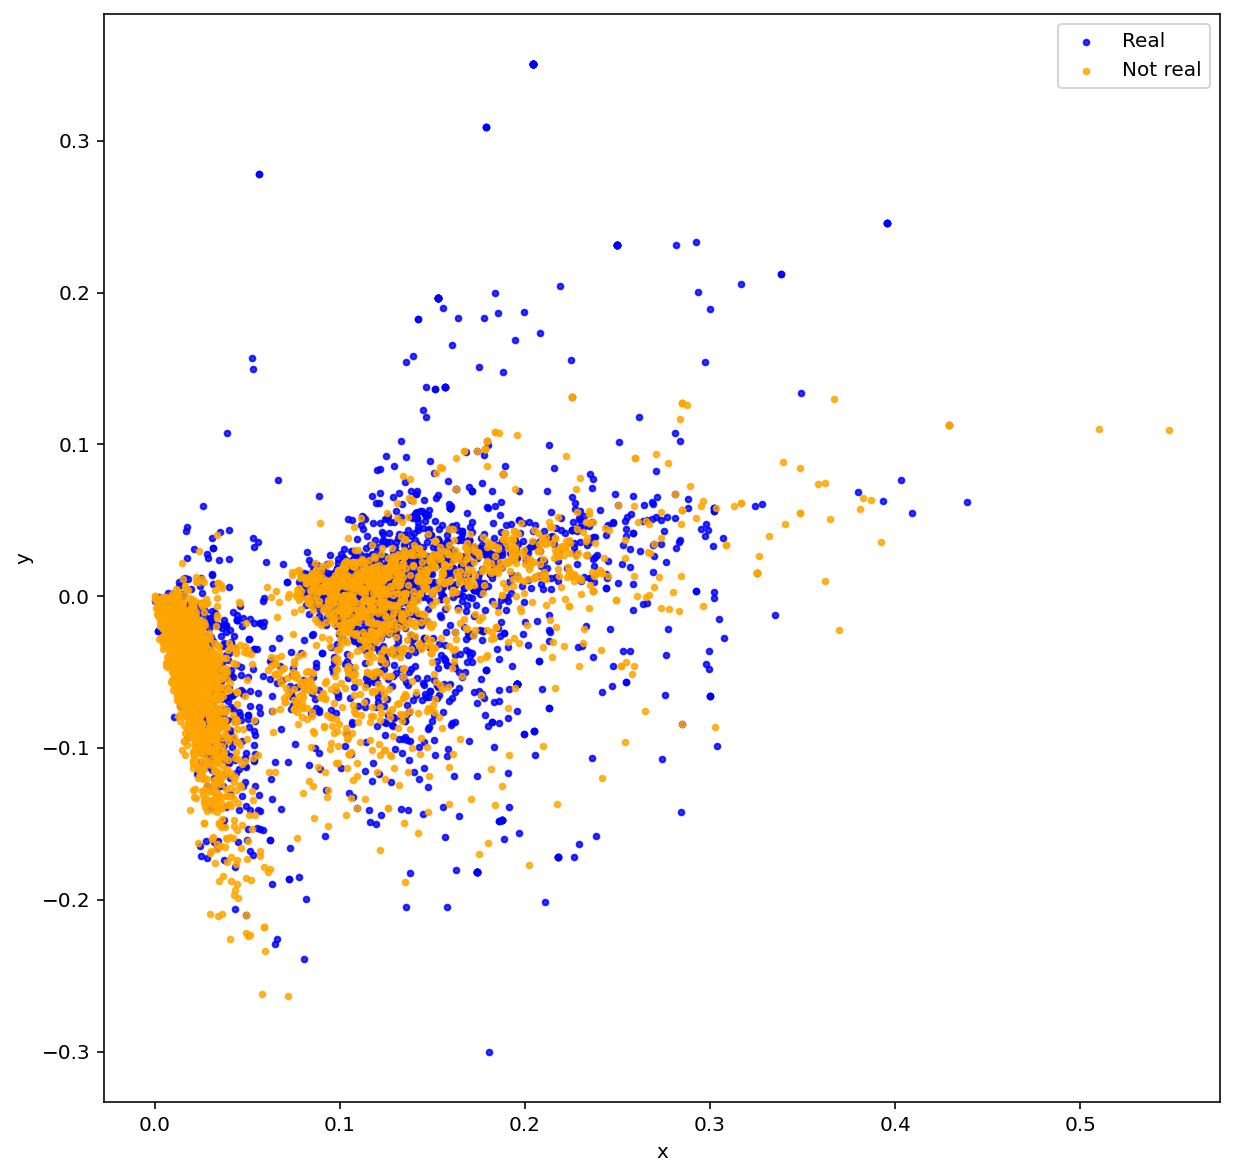

In [84]:
ax = to_plot[to_plot['target'] == 1].plot.scatter(x='x', y='y', s=8, alpha=0.8, color='blue', label='Real', figsize=(10, 10))
to_plot[to_plot['target'] == 0].plot.scatter(x='x', y='y', s=8, alpha=0.8, color='orange', label='Not real', ax=ax)

### TF-IDF

In [12]:
x_train, x_test, y_train, y_test = \
train_test_split(tweets['text'], tweets['target'], test_size = 0.25, random_state = 123)

In [13]:
tfid_vectorizer = TfidfVectorizer()
train_vectors = tfid_vectorizer.fit_transform(x_train)
test_vectors = tfid_vectorizer.transform(x_test)
print(train_vectors.shape, test_vectors.shape)

(5709, 11191) (1904, 11191)


#### Basic Naive Bayes 

En el caso de una predicción binaria es recomendable bernoulli

In [17]:
from sklearn.naive_bayes import BernoulliNB

bernoulli = BernoulliNB().fit(train_vectors, y_train)

In [18]:
predicted = bernoulli.predict(test_vectors)
print(accuracy_score(y_test, predicted))

0.8046218487394958


#### Tunning

In [25]:
tfid_matrix = tfid_vectorizer.transform(x_train)
array = tfid_matrix.todense()

In [26]:
df = pd.DataFrame(array)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,11181,11182,11183,11184,11185,11186,11187,11188,11189,11190
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
features = df.columns

In [35]:
alpha_b = np.linspace(0.1, 0.9, 20)
alpha_b = np.around(alpha_b, decimals=4)
alpha_b

array([0.1   , 0.1421, 0.1842, 0.2263, 0.2684, 0.3105, 0.3526, 0.3947,
       0.4368, 0.4789, 0.5211, 0.5632, 0.6053, 0.6474, 0.6895, 0.7316,
       0.7737, 0.8158, 0.8579, 0.9   ])

In [36]:
grid_m = [{"alpha":alpha_b}]

In [38]:
classifier = BernoulliNB()
gridsearch = GridSearchCV(classifier, grid_m, scoring = 'neg_log_loss', cv = 4)
gridsearch.fit(df[features], y_train)
print("Best parameter: ",gridsearch.best_params_)

Best parameter:  {'alpha': 0.9}


In [41]:
bernoulli_t = BernoulliNB(alpha=0.9).fit(train_vectors, y_train)
predicted_t = bernoulli_t.predict(test_vectors)
print(accuracy_score(y_test, predicted_t))

0.805672268907563


* Submit de prueba

In [52]:
test_vectors = tfid_vectorizer.transform(test['text'])
predicted_t = bernoulli_t.predict(test_vectors)
predicted_t

array([0, 0, 1, ..., 1, 1, 0])

In [60]:
test['target'] = predicted_t

In [65]:
submit_kaggle = test.loc[:, ['id', 'target']]
submit_kaggle.to_csv("submit_prueba_1.csv", index=False)

### LightGBM

* TF-IDF vectorization

In [114]:
vectorizer = TfidfVectorizer()
tfidf_lgbm = vectorizer.fit_transform(tweets.loc[:, 'text'])
array = tfidf_lgbm.todense()

In [117]:
df = pd.DataFrame(array)
df['output'] = tweets['target']
df['keyword'] = tweets['keyword'].fillna('none')
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,13294,13295,13296,13297,13298,13299,13300,13301,output,keyword
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,none


In [78]:
features = df.columns.drop('output')

In [99]:
x = df.loc[:, features].values
y = df.loc[:, 'output'].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 123)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [151]:
import lightgbm as lgb
d_train = lgb.Dataset(x_train, label=y_train)
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 100
params['max_depth'] = 50
params['max_bin'] = 50
params['num_iterations'] = 200
gbm = lgb.train(params, d_train,
                num_boost_round=100)

In [152]:
y_pred = clf.predict(x_test)

for i in range (0, len(y_pred)):
    if i <= 0.5:       
        y_pred[i] = 1 
    else:  
        y_pred[i]=0

In [153]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,y_test)

In [154]:
print(accuracy)

0.5756302521008403


### Word2Vec for keywords

In [24]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


In [64]:
keywords = tweets.loc[:,['keyword', 'id']]

In [80]:
keword_tokens = keywords.keyword.unique().tolist()

In [84]:
keword_tokens.remove(np.nan)

In [103]:
keword_tokens.append('none')

In [111]:
from gensim.models import Word2Vec

# Parameters
# sg ({0, 1}, optional) - Training algorithm: 1 for skip-gram; otherwise CBOW.

model = Word2Vec([keword_tokens], min_count=1, size= 50, workers=3, window =3, sg=1)

In [112]:
# Sanity check
model['ablaze']

/Users/matiascano/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.00061099, -0.00289875,  0.00838791,  0.00187828,  0.00324505,
       -0.0082288 , -0.0062319 , -0.00554615, -0.00149595, -0.00047399,
        0.00870861,  0.00162546,  0.00353757,  0.00911924, -0.00593509,
        0.00396049,  0.00533404, -0.00246731,  0.00155831, -0.00210602,
        0.00427562, -0.0016644 , -0.00209612,  0.00750811, -0.00457047,
       -0.00539172, -0.00159892,  0.00275782,  0.00870683,  0.00763916,
       -0.00684021,  0.00264381, -0.00877205, -0.00970513, -0.00715766,
       -0.00995904,  0.0023487 , -0.00544489,  0.00633188,  0.0080406 ,
       -0.00661281, -0.00901994, -0.00050668,  0.00394214,  0.00633971,
       -0.00259138, -0.0066215 , -0.00582752,  0.00289046,  0.00708582],
      dtype=float32)